# PyCBC Inference code road map
### Collin Capano and Sebastian Khan

To illustrate how `pycbc_inference` works, we replicate the steps the program takes to setup and run the `emcee` sampler on the analytic 2D Normal distribution. We will use the same prior and setup as described in the Intro to PyCBC Inference tutorial. Instead of using a config file, we setup and the prior, sampler, and model directly.

### Prerequisites

In [1]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import os
import numpy

import pycbc
from pycbc import distributions
from pycbc import inference
from pycbc.inference import models

In [5]:
pycbc.init_logging(True)

## PyCBC Inference call graph

The following is a call graph showing the modules and classes `pycbc_inference` calls when it is running. Note:
 * A `sampler` class is used to interface with the sampling engines, like `emcee_pt`.
 * The sampler communicates with a `model` class. This calculates the `loglikelihood` and calls a `JointDistribution` to calculate the `logprior`.
 * When analyzing gravitational-wave data, the `model` also calls the waveform generator to generate a waveform. However, since we will be using a test distribution, this step is not taken in this notebook.

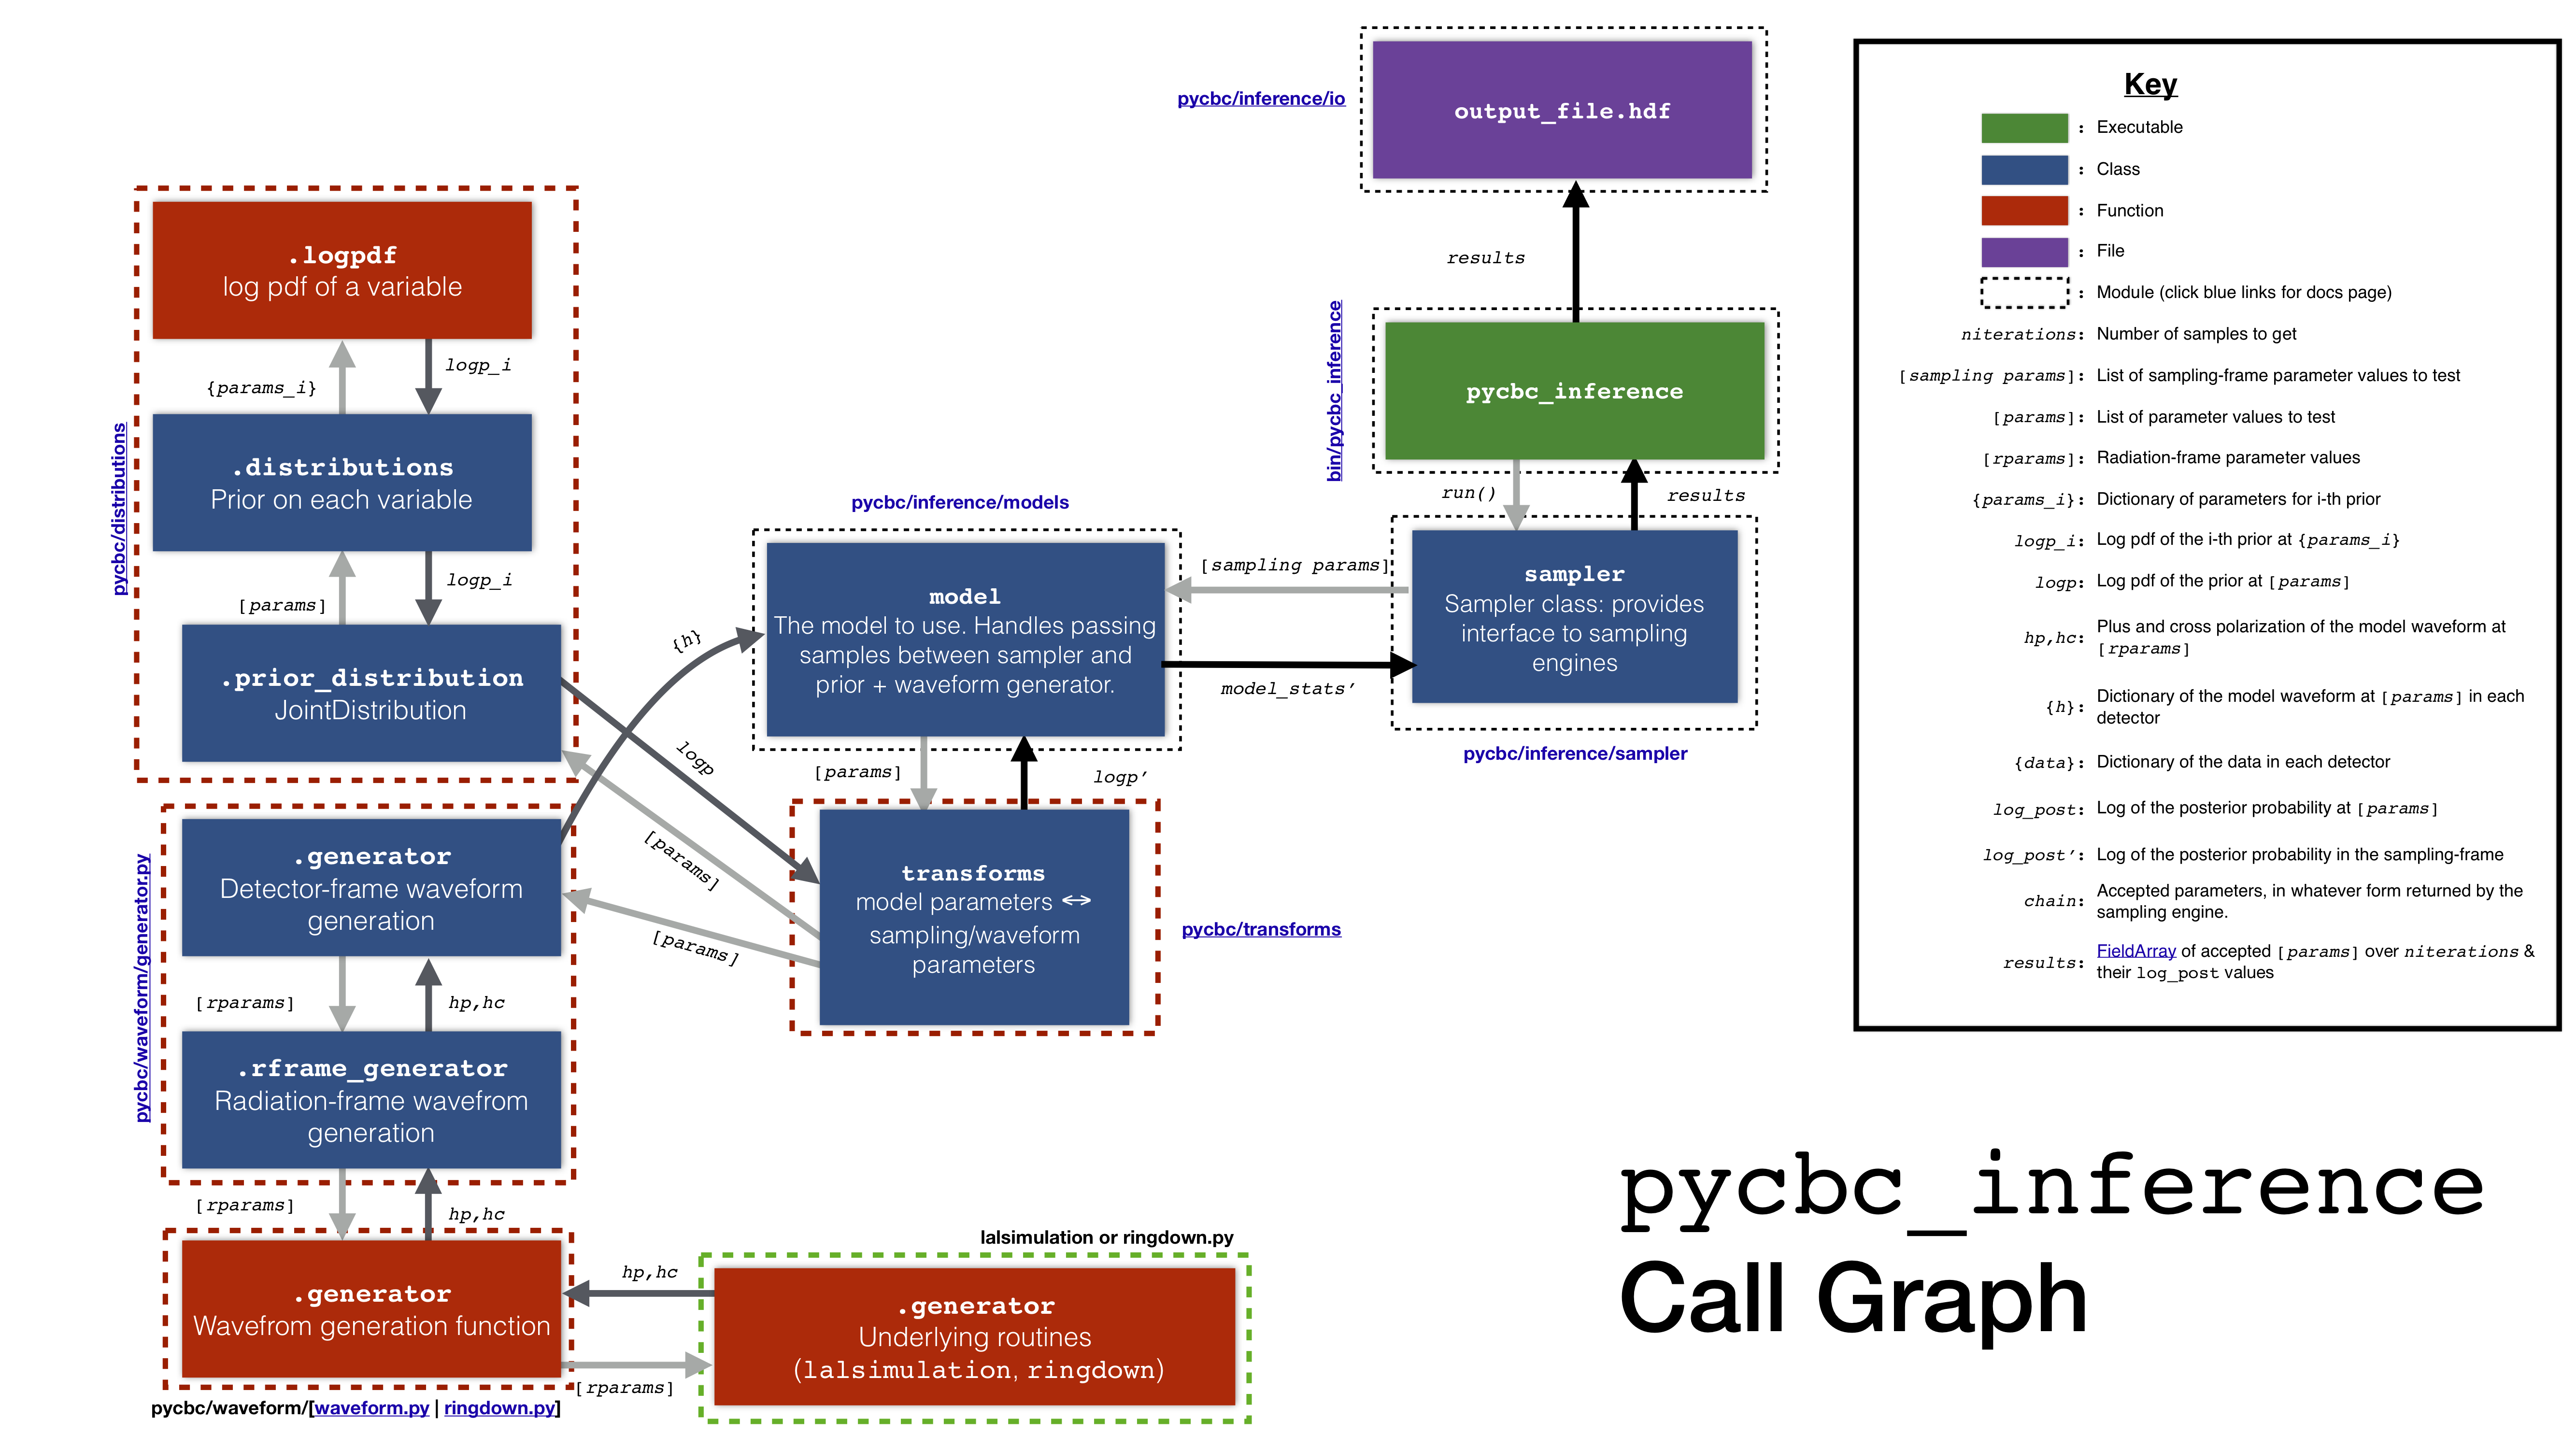

In [6]:
from IPython.display import Image
Image("pycbc_inference_callgraph.png")

## 1. Set up the prior

We first need to create an instance of the `Uniform` distribution.

In [7]:
xdist = distributions.Uniform(x=(-10, 10))
ydist = distributions.Uniform(y=(-10, 10))

Now we need to create a `JointDistribution` to handle the two distributions:

In [8]:
jointdist = distributions.JointDistribution(["x","y"], xdist, ydist)

## 2. Set up the model

We now create a `model` instance. We will tell it that it has two parameters, called `x` and `y`, and we provide the `jointdist` as the prior.

In [9]:
model = models.models["test_normal"](["x","y"], prior=jointdist)

The model can produce random draws from the prior:

In [10]:
random_draws = model.prior_rvs(size=3)
print('x:', random_draws['x'])
print('y:', random_draws['y'])

x: [-5.66283528 -2.57850803  3.97451432]
y: [0.99961158 8.40710377 4.65446088]


The model is what evaluates the `logprior` and `loglikelihood` values. We do that by first providing it a point to evaluate; we will use the first point from our random draw:

In [11]:
test_point_x = random_draws['x'][0]
test_point_y = random_draws['y'][0]
print(test_point_x, test_point_y)

-5.662835283442713 0.9996115761997366


In [12]:
model.update(x=test_point_x, y=test_point_y)

We can now get the `logprior` and `loglikelihood` values by calling the appropriate attributes:

In [13]:
print("logprior at point:", model.logprior)
print("loglikelihood at point:", model.loglikelihood)

logprior at point: -5.991464547107982
loglikelihood at point: -18.371340441747464


Or, we can call `logposterior` which is the sum of the `logprior` and `loglikelihood` values:

In [14]:
model.logposterior

-24.362804988855444

When the sampler runs, it calls `model.update` for each new point it wants to test, then gets the statistics it needs.

## 3. Set up the sampler

With the model initialized, we can now set up the sampler:

### a. Initialize

In [15]:
sampler = inference.sampler.emcee.EmceeEnsembleSampler(model, nwalkers=1000, checkpoint_interval=100,
                                                       nprocesses=4)

### b. Set the output file

We need to provide an output file that the sampler can write the samples to. The function `setup_output` in `pycbc.inference.sampler.base` takes care of setting up a fresh output file for us, and setting the necessary sampler attributes. We'll call the file `normal2d.hdf`. The function `setup_output` will actually create a file called `normal2d.hdf.checkpoint`, and `normal2.hdf.bkup`. Results are written to these files every time the sampler checkpoints, which for `emcee` occurs after the sampler has run for `checkpoint_interval` iterations.

In [16]:
output_filename = "normal2d.hdf"
# if the checkpoint file already exists, the sampler will try to
# load that file and run from it; since we want a fresh run here,
# we first need to remove it
for ftype in ['.checkpoint', '.bkup']:
    fname = output_filename + ftype
    if os.path.exists(fname):
        os.remove(fname)

# now setup the output file
inference.sampler.base.setup_output(sampler, output_filename)

2020-03-03 16:42:50,018 Looking for checkpoint file
2020-03-03 16:42:50,020 Checkpoint not found or not valid
2020-03-03 16:42:50,022 Creating file normal2d.hdf.checkpoint


### c. Set the termination condition

In this case, we will run for 200 iterations.

In [17]:
sampler.set_target(niterations=200)

### d. Set the starting point

For the `emcee` sampler (and all of the MCMC samplers), we need to set a starting position for all of the walkers/chains. We can do this by calling `sampler.set_p0()`. If we provide no arguments, this will draw random samples from the prior distribution. Alternatively, if we want to set the starting positions using a different distribution than the prior, we could provide a `prior` argument to this function and point it at a different `JointDistribution` instance.

In [18]:
# set_p0 returns the positions that were set as a dictionary;
# we don't really care about that, so we'll silence the output
_ = sampler.set_p0()

## 3. Run the sampler

In [19]:
sampler.run()

2020-03-03 16:42:50,149 Running sampler for 0 to 100 iterations
2020-03-03 16:42:55,958 Writing samples to normal2d.hdf.checkpoint with thin interval 1
2020-03-03 16:42:56,018 Writing samples to normal2d.hdf.bkup with thin interval 1
2020-03-03 16:42:56,074 Computing acls
2020-03-03 16:42:56,410 ACT: 13
2020-03-03 16:42:56,418 Validating checkpoint and backup files
2020-03-03 16:42:56,454 Clearing samples from memory
2020-03-03 16:42:56,479 Running sampler for 100 to 200 iterations
2020-03-03 16:43:02,078 Writing samples to normal2d.hdf.checkpoint with thin interval 1
2020-03-03 16:43:02,138 Writing samples to normal2d.hdf.bkup with thin interval 1
2020-03-03 16:43:02,196 Computing acls
2020-03-03 16:43:02,216 ACT: 12
2020-03-03 16:43:02,222 Validating checkpoint and backup files
2020-03-03 16:43:02,270 Clearing samples from memory


The run command runs the sampler until the termination condition set by `set_target` is met (in this case, when it reaches 200 iterations), checkpointing along the way. The results were dumped to the checkpoint file.

## Plot the results

We can load the samples from the checkpoint file and plot them.

In [20]:
fp = inference.io.loadfile("normal2d.hdf.checkpoint", "r")

In [21]:
samples = fp.read_samples(['x', 'y', 'loglikelihood'])

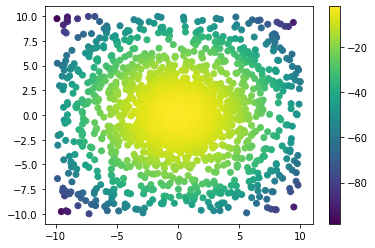

In [22]:
plt.figure()
plt.scatter(samples['x'], samples['y'], c=samples['loglikelihood'])
plt.colorbar()
plt.show()

In [23]:
fp.close()